<IMG SRC="https://avatars2.githubusercontent.com/u/31697400?s=400&u=a5a6fc31ec93c07853dd53835936fd90c44f7483&v=4" WIDTH=125 ALIGN="right">


# Modpath

This notebook shows how to create a particle tracking model using modpath.
    
# To-Do
- make the examples from a package and from a model layer faster
- update toc    
- add cross section

### Contents<a name="TOC"></a>
1. [Groundwater Flow Model](#model)
2. [Modpath](#modpath)

In [25]:
import os
import sys
import nlmod
import flopy
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import logging

In [2]:
print(f'nlmod version: {nlmod.__version__}')

# toon informatie bij het aanroepen van functies
logging.basicConfig(level=logging.INFO)

nlmod version: 0.2.5b


### [1. Groundwater Flow Model](#TOC)<a name="model"></a>

We use the groundwater flow model from the [03_local_grid_refinement notebook](03_local_grid_refinement). Make sure to run this notebook before you run this notebook

In [3]:
# load lgr model dataset
model_ws = 'model3'
model_name = 'IJm_planeten'

model_ds = xr.open_dataset(os.path.join(model_ws, "cache", "full_model_ds.nc"))

In [4]:
# load lgr simulation and groundwateflow model
# set exe_name to point to mf6 version in nlmod bin directory
exe_name = os.path.join(os.path.dirname(nlmod.__file__),
                        'bin', 'mf6')
if sys.platform.startswith('win'):
    exe_name += ".exe"
    
sim = flopy.mf6.MFSimulation.load("mfsim.nam", sim_ws=model_ws, exe_name=exe_name)
gwf = sim.get_model(model_name=model_name)

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package disv...
    loading package npf...
    loading package ic...
    loading package oc...
    loading package ghb...
    loading package drn...
    loading package chd...
    loading package rch...
  loading ims package ijm_planeten...


### [2. Modpath](#TOC)<a name="modpath"></a>



### 2.1 Backward tracking

In [5]:
# list with xy coordinates to start particle tracking from 
xy_start = [(101500, 496500), (101500,499100)]

# create a modpath model
mpf = nlmod.modpath.mpf(gwf)

# create the basic modpath package
_mpfbas = nlmod.modpath.bas(mpf)

# find the nodes for given xy
nodes = nlmod.modpath.xy_to_nodes(xy_start, mpf, model_ds, layer=5)

# create a particle tracking group at the cell faces
pg = nlmod.modpath.pg_from_fdt(nodes)

# create the modpath simulation file
mpsim = nlmod.modpath.sim(mpf, pg, 'backward', gwf=gwf)

INFO:nlmod.mfpackages.modpath:particle group with 9 particle per cell face, 54 particles per cell


adding Package:  MPBAS
adding Package:  MPSIM


In [6]:
# run modpath model
nlmod.modpath.write_and_run_model(mpf, nb_path='10_modpath.ipynb')

INFO:nlmod.mfpackages.modpath:removed 'mp7_ijm_planeten_f.mppth'
INFO:nlmod.mfpackages.modpath:removed 'mp7_ijm_planeten_f.timeseries'
INFO:nlmod.mfpackages.modpath:removed 'mp7_ijm_planeten_f.mpend'
INFO:nlmod.mfpackages.modpath:write script 2022082510_modpath.ipynb to modpath workspace
INFO:nlmod.mfpackages.modpath:write modpath files to model workspace
INFO:nlmod.mfpackages.modpath:run modpath model



Writing packages:
   Package:  MPBAS
   Package:  MPSIM
 
FloPy is using the following  executable to run the model: c:\users\oebbe\02_python\nlmod\nlmod\mfpackages\..\bin\mp7.exe

MODPATH Version 7.2.002 PROVISIONAL 
Program compiled Nov 23 2021 09:33:21 with IFORT compiler (ver. 19.0.5)         
 
 
Run particle tracking simulation ...
Processing Time Step     1 Period     6.  Time =  3.65700E+03  Steady-state flow                                                    
Processing Time Step     1 Period     5.  Time =  3.65600E+03  Steady-state flow                                                    
Processing Time Step     1 Period     4.  Time =  3.65500E+03  Steady-state flow                                                    
Processing Time Step     1 Period     3.  Time =  3.65400E+03  Steady-state flow                                                    
Processing Time Step     1 Period     2.  Time =  3.65300E+03  Steady-state flow                                               

In [7]:
pdata = nlmod.mfpackages.modpath.load_pathline_data(mpf)

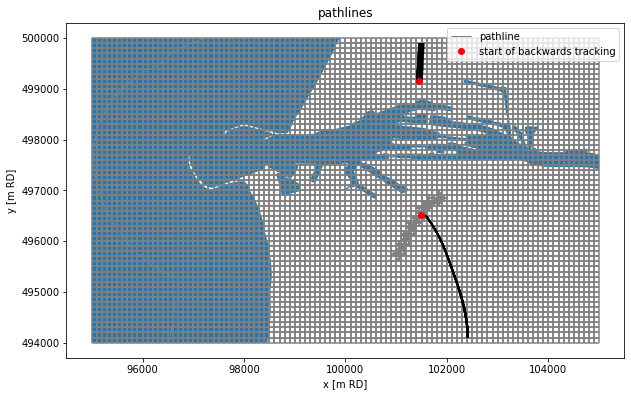

In [8]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
ax.set_aspect("equal")
ax = nlmod.visualise.plots.plot_modelgrid(model_ds, gwf, ax=ax)

for pid in np.unique(pdata['particleid']):
    pf = pdata[pdata['particleid']==pid]
    ax.plot(pf['x'],pf['y'], color="k", linewidth=0.5)
ax.plot(pf['x'],pf['y'], color="k", linewidth=0.5, label='pathline')

cids = [nlmod.mdims.xy_to_icell2d(xy, model_ds) for xy in xy_start]
ax.plot(model_ds.x[cids],model_ds.y[cids], label='start of backwards tracking', ls='', marker='o', color='red')
ax.set_title(f'pathlines')
ax.legend();

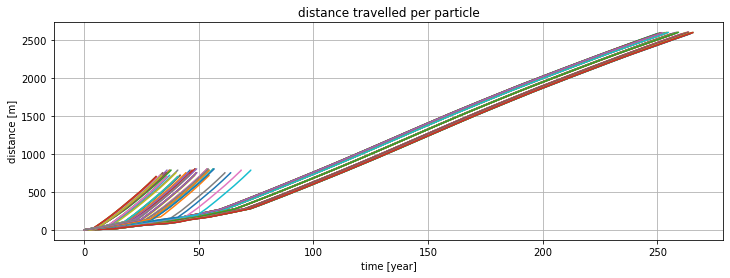

In [9]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))

for i, pid in enumerate(np.unique(pdata['particleid'])):
    pf = pdata[pdata['particleid']==pid]
    x0,y0,z0 = pf[['x','y','z']][0]
    distance = np.sqrt((pf['x'] - x0)**2 + (pf['y'] - y0)**2 + (pf['z'] - z0)**2)
    ax.plot(pf['time']/365.25,distance, label=pid)

ax.set_ylabel('distance [m]')
ax.set_xlabel('time [year]')
ax.set_title('distance travelled per particle')
ax.grid()

### 2.2 Forward tracking

In [10]:
# list with xy coordinates to start particle tracking from 
xy_start = [(101500, 496500), (101500,499100)]

# create a modpath model
mpf = nlmod.mfpackages.modpath.mpf(gwf)

# create the basic modpath package
_mpfbas = nlmod.mfpackages.modpath.bas(mpf)

# find the nodes for given xy
nodes = nlmod.mfpackages.modpath.xy_to_nodes(xy_start, mpf, model_ds, layer=5)

# create a particle tracking group at the cell faces
#pg = nlmod.mfpackages.modpath.pg_from_pd(nodes, localx=0.5, localy=0.5, localz=1.0)
pg = nlmod.mfpackages.modpath.pg_from_fdt(nodes)

# create the modpath simulation file
mpsim = nlmod.mfpackages.modpath.sim(mpf, pg, 'forward')

INFO:nlmod.mfpackages.modpath:particle group with 9 particle per cell face, 54 particles per cell


adding Package:  MPBAS
adding Package:  MPSIM


In [11]:
# run modpath model
nlmod.mfpackages.modpath.write_and_run_model(mpf, nb_path='10_modpath.ipynb')

INFO:nlmod.mfpackages.modpath:removed 'mp7_ijm_planeten_f.mppth'
INFO:nlmod.mfpackages.modpath:removed 'mp7_ijm_planeten_f.timeseries'
INFO:nlmod.mfpackages.modpath:removed 'mp7_ijm_planeten_f.mpend'
INFO:nlmod.mfpackages.modpath:write script 2022082510_modpath.ipynb to modpath workspace
INFO:nlmod.mfpackages.modpath:write modpath files to model workspace
INFO:nlmod.mfpackages.modpath:run modpath model



Writing packages:
   Package:  MPBAS
   Package:  MPSIM
 
FloPy is using the following  executable to run the model: c:\users\oebbe\02_python\nlmod\nlmod\mfpackages\..\bin\mp7.exe

MODPATH Version 7.2.002 PROVISIONAL 
Program compiled Nov 23 2021 09:33:21 with IFORT compiler (ver. 19.0.5)         
 
 
Run particle tracking simulation ...
Processing Time Step     1 Period     1.  Time =  3.65200E+03  Steady-state flow                                                    
Processing Time Step     1 Period     2.  Time =  3.65300E+03  Steady-state flow                                                    
Processing Time Step     1 Period     3.  Time =  3.65400E+03  Steady-state flow                                                    
Processing Time Step     1 Period     4.  Time =  3.65500E+03  Steady-state flow                                                    
Processing Time Step     1 Period     5.  Time =  3.65600E+03  Steady-state flow                                               

In [12]:
pdata = nlmod.mfpackages.modpath.load_pathline_data(mpf)

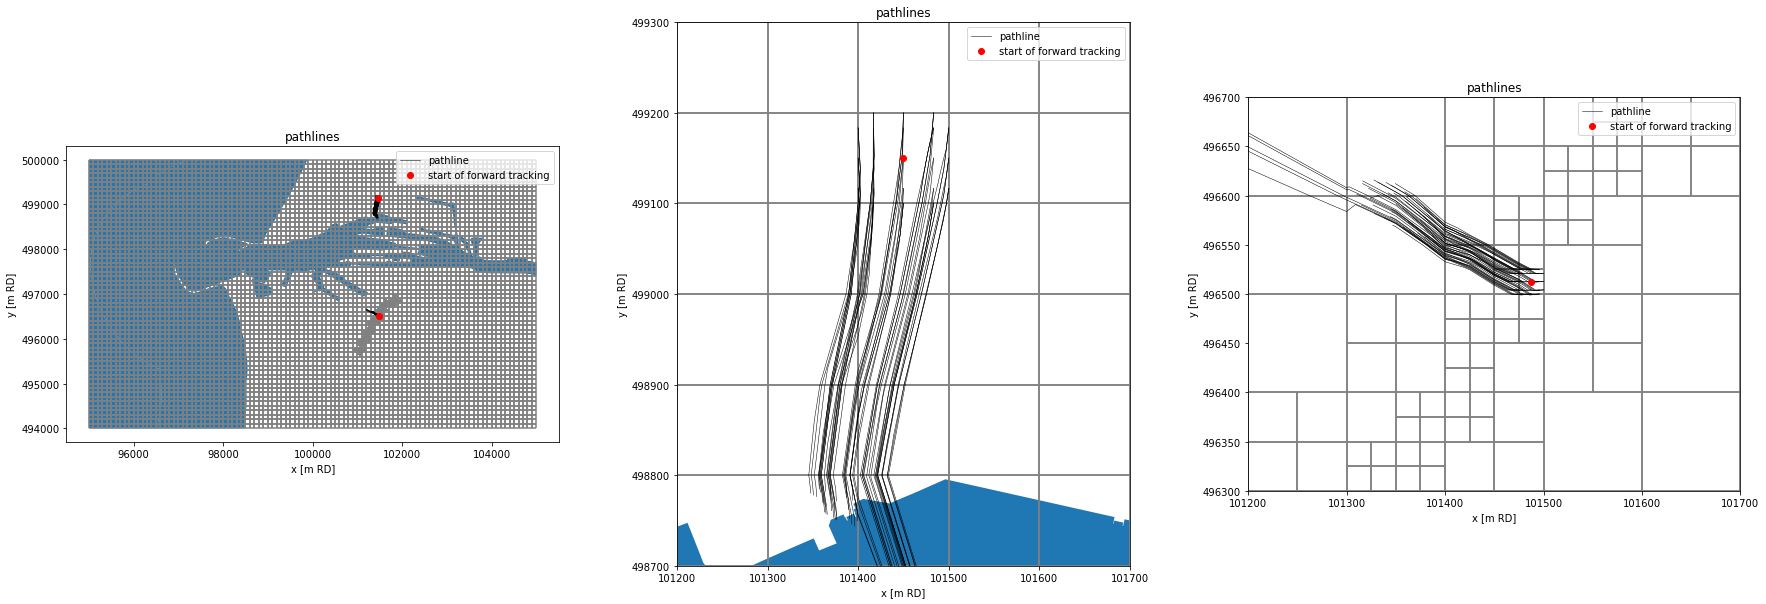

In [13]:
f, axl = plt.subplots(nrows=1, ncols=3, figsize=(30, 10))
for i, ax in enumerate(axl):
    ax.set_aspect("equal")
    ax = nlmod.visualise.plots.plot_modelgrid(model_ds, gwf, ax=ax)

    for pid in np.unique(pdata['particleid']):
        pf = pdata[pdata['particleid']==pid]
        ax.plot(pf['x'],pf['y'], color="k", linewidth=0.5)
    ax.plot(pf['x'],pf['y'], color="k", linewidth=0.5, label='pathline')

    cids = [nlmod.mdims.xy_to_icell2d(xy, model_ds) for xy in xy_start]
    ax.plot(model_ds.x[cids],model_ds.y[cids], label='start of forward tracking', ls='', marker='o', color='red')
    ax.set_title(f'pathlines')
    ax.legend();
    
    if i==1:
        ax.set_xlim(101200, 101700)
        ax.set_ylim(498700, 499300)
    elif i==2:
        ax.set_xlim(101200, 101700)
        ax.set_ylim(496300, 496700)

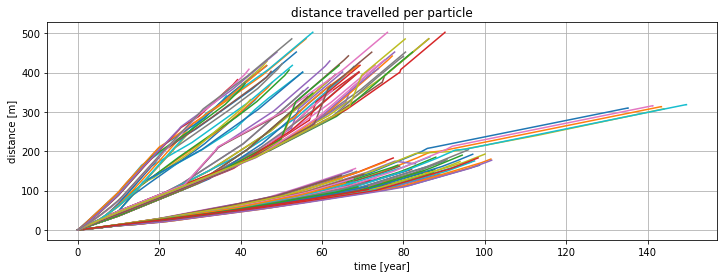

In [14]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))

for i, pid in enumerate(np.unique(pdata['particleid'])):
    pf = pdata[pdata['particleid']==pid]
    x0,y0,z0 = pf[['x','y','z']][0]
    distance = np.sqrt((pf['x'] - x0)**2 + (pf['y'] - y0)**2 + (pf['z'] - z0)**2)
    ax.plot(pf['time']/365.25,distance, label=pid)

ax.set_ylabel('distance [m]')
ax.set_xlabel('time [year]')
ax.set_title('distance travelled per particle')
ax.grid()

### 2.3 Backward tracking from general head boundaries

In [15]:
# create a modpath model
mpf = nlmod.modpath.mpf(gwf)

# create the basic modpath package
_mpfbas = nlmod.modpath.bas(mpf)

# get the nodes from a package
nodes = nlmod.modpath.package_to_nodes(gwf, 'GHB_0', mpf)

# create a particle tracking group from cell centers
pg = nlmod.modpath.pg_from_pd(nodes, localx=0.5, localy=0.5, localz=0.5)

# create the modpath simulation file
mpsim = nlmod.modpath.sim(mpf, pg, 'backward', gwf=gwf)

adding Package:  MPBAS
adding Package:  MPSIM


In [16]:
# run modpath model
nlmod.modpath.write_and_run_model(mpf, nb_path='10_modpath.ipynb')

INFO:nlmod.mfpackages.modpath:removed 'mp7_ijm_planeten_f.mppth'
INFO:nlmod.mfpackages.modpath:removed 'mp7_ijm_planeten_f.timeseries'
INFO:nlmod.mfpackages.modpath:removed 'mp7_ijm_planeten_f.mpend'
INFO:nlmod.mfpackages.modpath:write script 2022082510_modpath.ipynb to modpath workspace
INFO:nlmod.mfpackages.modpath:write modpath files to model workspace
INFO:nlmod.mfpackages.modpath:run modpath model



Writing packages:
   Package:  MPBAS
   Package:  MPSIM
 
FloPy is using the following  executable to run the model: c:\users\oebbe\02_python\nlmod\nlmod\mfpackages\..\bin\mp7.exe

MODPATH Version 7.2.002 PROVISIONAL 
Program compiled Nov 23 2021 09:33:21 with IFORT compiler (ver. 19.0.5)         
 
 
Run particle tracking simulation ...
Processing Time Step     1 Period     6.  Time =  3.65700E+03  Steady-state flow                                                    
Processing Time Step     1 Period     5.  Time =  3.65600E+03  Steady-state flow                                                    
Processing Time Step     1 Period     4.  Time =  3.65500E+03  Steady-state flow                                                    
Processing Time Step     1 Period     3.  Time =  3.65400E+03  Steady-state flow                                                    
Processing Time Step     1 Period     2.  Time =  3.65300E+03  Steady-state flow                                               

In [17]:
pdata = nlmod.modpath.load_pathline_data(mpf)

C:\Users\oebbe\anaconda3\envs\nlmod\lib\site-packages\geopandas\plotting.py:482: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.draw()
C:\Users\oebbe\anaconda3\envs\nlmod\lib\site-packages\geopandas\plotting.py:482: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.draw()
C:\Users\oebbe\anaconda3\envs\nlmod\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


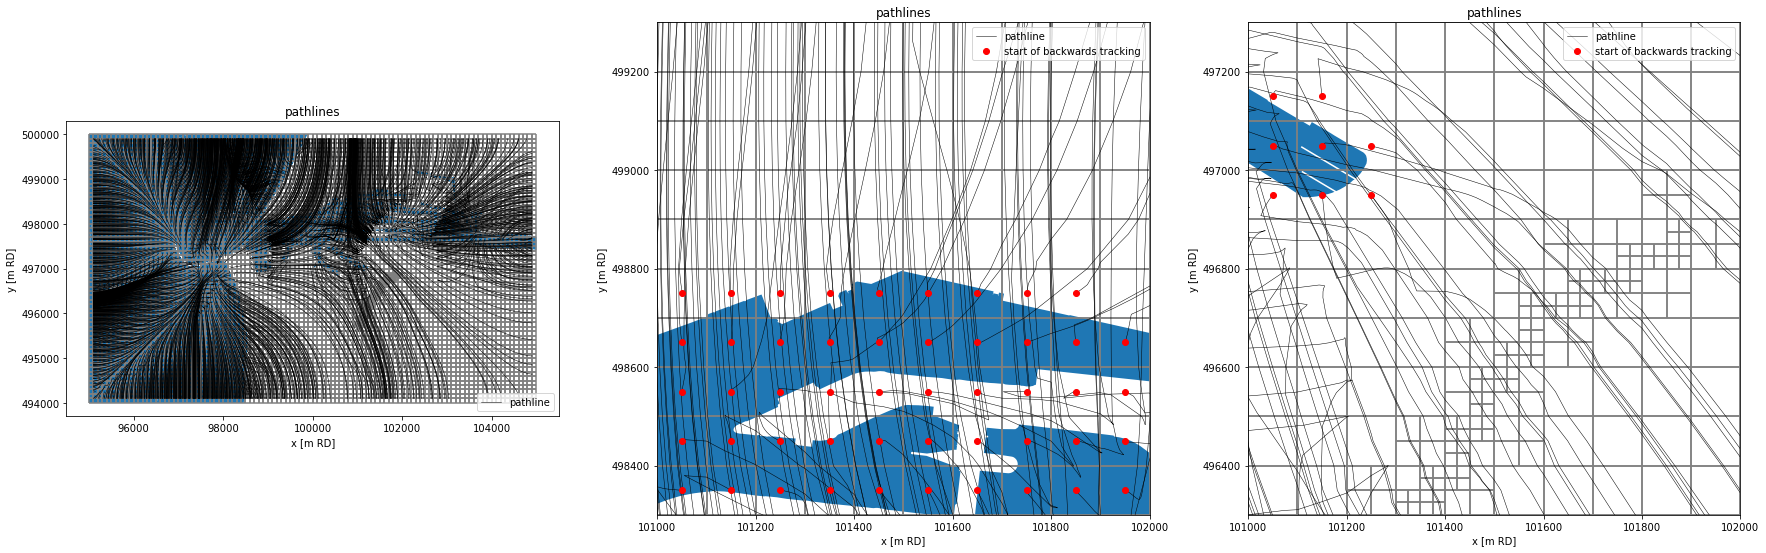

In [18]:
f, axl = plt.subplots(nrows=1, ncols=3, figsize=(30, 10))
for i, ax in enumerate(axl):
    ax.set_aspect("equal")
    ax = nlmod.visualise.plots.plot_modelgrid(model_ds, gwf, ax=ax)

    for pid in np.unique(pdata['particleid']):
        pf = pdata[pdata['particleid']==pid]
        ax.plot(pf['x'],pf['y'], color="k", linewidth=0.5)
    ax.plot(pf['x'],pf['y'], color="k", linewidth=0.5, label='pathline')

    if i>0:
        cids = np.where((model_ds['rws_oppwater_cond']!=0).values)[0]
        ax.plot(model_ds.x[cids],model_ds.y[cids], label='start of backwards tracking', ls='', marker='o', color='red')
    ax.set_title(f'pathlines')
    ax.legend();
    
    if i==1:
        ax.set_xlim(101000, 102000)
        ax.set_ylim(498300, 499300)
    elif i==2:
        ax.set_xlim(101000, 102000)
        ax.set_ylim(496300, 497300)

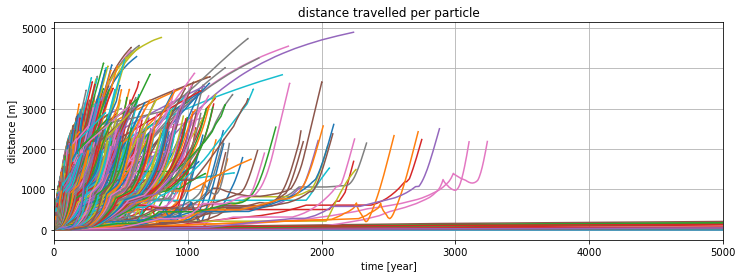

In [19]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))

for i, pid in enumerate(np.unique(pdata['particleid'])):
    pf = pdata[pdata['particleid']==pid]
    x0,y0,z0 = pf[['x','y','z']][0]
    distance = np.sqrt((pf['x'] - x0)**2 + (pf['y'] - y0)**2 + (pf['z'] - z0)**2)
    ax.plot(pf['time']/365.25,distance, label=pid)

ax.set_xlim(0, 5000)
ax.set_ylabel('distance [m]')
ax.set_xlabel('time [year]')
ax.set_title('distance travelled per particle')
ax.grid()

### 2.4 Forward tracking from each cell in the top layer

Stop after 10 years.

In [20]:
# create a modpath model
mpf = nlmod.modpath.mpf(gwf)

# create the basic modpath package
_mpfbas = nlmod.modpath.bas(mpf)

# get nodes of all cells in the top modellayer
nodes = nlmod.modpath.layer_to_nodes(mpf, 0)

# create a particle tracking group from cell centers
pg = nlmod.modpath.pg_from_pd(nodes, localx=0.5, localy=0.5, localz=0.5)

# create the modpath simulation file
mpsim = nlmod.modpath.sim(mpf, pg, 'forward', gwf=gwf, stoptime=10*365)

adding Package:  MPBAS
adding Package:  MPSIM


In [21]:
# run modpath model
nlmod.modpath.write_and_run_model(mpf, nb_path='10_modpath.ipynb')

INFO:nlmod.mfpackages.modpath:removed 'mp7_ijm_planeten_f.mppth'
INFO:nlmod.mfpackages.modpath:removed 'mp7_ijm_planeten_f.timeseries'
INFO:nlmod.mfpackages.modpath:removed 'mp7_ijm_planeten_f.mpend'
INFO:nlmod.mfpackages.modpath:write script 2022082510_modpath.ipynb to modpath workspace
INFO:nlmod.mfpackages.modpath:write modpath files to model workspace
INFO:nlmod.mfpackages.modpath:run modpath model



Writing packages:
   Package:  MPBAS
   Package:  MPSIM
 
FloPy is using the following  executable to run the model: c:\users\oebbe\02_python\nlmod\nlmod\mfpackages\..\bin\mp7.exe

MODPATH Version 7.2.002 PROVISIONAL 
Program compiled Nov 23 2021 09:33:21 with IFORT compiler (ver. 19.0.5)         
 
 
Run particle tracking simulation ...
Processing Time Step     1 Period     1.  Time =  3.65200E+03  Steady-state flow                                                    

Particle Summary:
         0 particles are pending release.
      1817 particles remain active.
         0 particles terminated at boundary faces.
         0 particles terminated at weak sink cells.
         0 particles terminated at weak source cells.
       231 particles terminated at strong source/sink cells.
         0 particles terminated in cells with a specified zone number.
         0 particles were stranded in inactive or dry cells.
         0 particles were unreleased.
         0 particles have an unknown stat

In [22]:
pdata = nlmod.modpath.load_pathline_data(mpf)

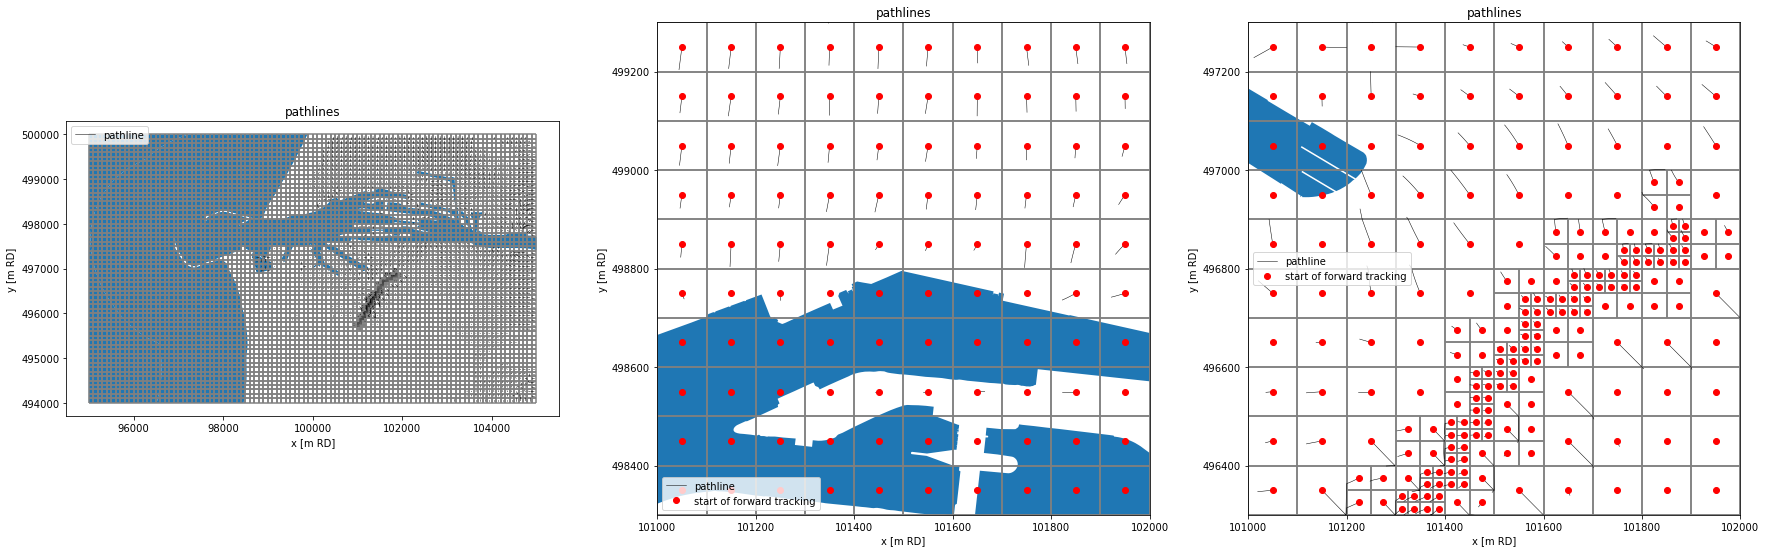

In [23]:
f, axl = plt.subplots(nrows=1, ncols=3, figsize=(30, 10))
for i, ax in enumerate(axl):
    ax.set_aspect("equal")
    ax = nlmod.visualise.plots.plot_modelgrid(model_ds, gwf, ax=ax)

    for pid in np.unique(pdata['particleid']):
        pf = pdata[pdata['particleid']==pid]
        ax.plot(pf['x'],pf['y'], color="k", linewidth=0.5)
    ax.plot(pf['x'],pf['y'], color="k", linewidth=0.5, label='pathline')

    if i>0:
        ax.plot(model_ds.x.values,model_ds.y.values, label='start of forward tracking', ls='', marker='o', color='red')
    ax.set_title(f'pathlines')
    ax.legend();
    
    if i==1:
        ax.set_xlim(101000, 102000)
        ax.set_ylim(498300, 499300)
    elif i==2:
        ax.set_xlim(101000, 102000)
        ax.set_ylim(496300, 497300)

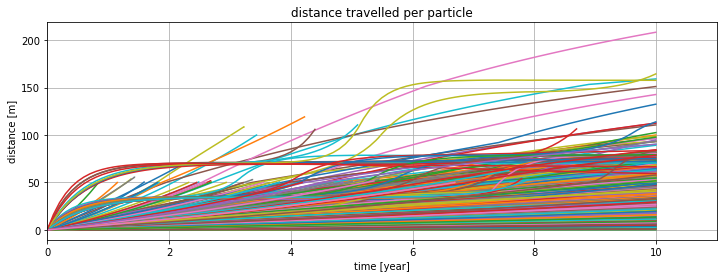

In [24]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))

for i, pid in enumerate(np.unique(pdata['particleid'])):
    pf = pdata[pdata['particleid']==pid]
    x0,y0,z0 = pf[['x','y','z']][0]
    distance = np.sqrt((pf['x'] - x0)**2 + (pf['y'] - y0)**2 + (pf['z'] - z0)**2)
    ax.plot(pf['time']/365.25,distance, label=pid)

ax.set_xlim(0, 11)
ax.set_ylabel('distance [m]')
ax.set_xlabel('time [year]')
ax.set_title('distance travelled per particle')
ax.grid()